In [ ]:
!pip install groq
! pip install pygraphviz pyppeteer


In [ ]:
! pip install langgraph langchain-community pypdf faiss-cpu sentence-transformers langchain-groq

In [20]:
from dotenv import load_dotenv
load_dotenv()

True

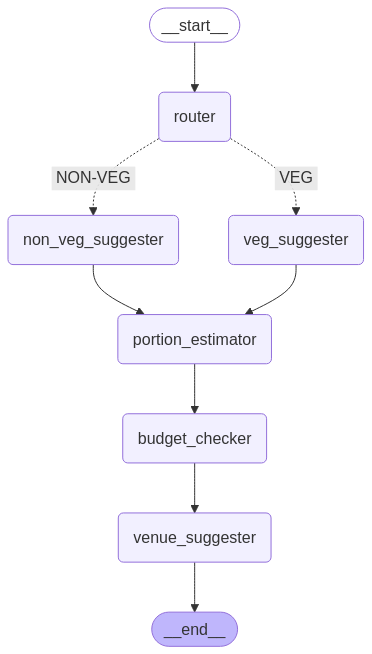

Suggested Food: 1. Biryani
2. Haleem
3. Seekh Kebab
4. Nihari
5. Chicken Korma
Portion Estimate: Here's an estimated portion guide for 20 guests, keeping in mind that appetites can vary:

**Dish** | **Estimated Portions** | **Notes**
------- | -------- | --------
**Biryani** | 2-3 cups per person |  Consider serving with raita and salad for a balanced meal.
**Haleem** | 1-1.5 cups per person |  A hearty dish, so a smaller portion might suffice.
**Seekh Kebab** | 4-6 kebabs per person |  Serve with naan or roti for a complete meal.
**Nihari** | 1-1.5 cups per person |  A rich and flavorful stew, so a smaller portion is recommended.
**Chicken Korma** | 1-1.5 cups per person |  Serve with rice or naan.

**Important Considerations:**

* **Appetites:**  Are your guests known for big appetites? Adjust portions accordingly.
* **Other Dishes:**  Will you be serving appetizers, sides, or desserts? This will influence the main course portions.
* **Dietary Restrictions:**  Are there any vegetaria

In [31]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage

# Define the state structure
class IftariState(TypedDict):
    user_preference: str | None
    guest_count: int | None
    budget: float | None
    food_suggestion: str | None
    portion_estimate: str | None
    budget_check: str | None
    venue_suggestion: str | None

# Agent 1: Classifies dietary preference
def preference_router(state: IftariState) -> dict:
    preference_prompt = "Classify dietary preference as VEG or NON-VEG. Return only one word."

    model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    response = model.invoke([
        SystemMessage(content=preference_prompt),
        HumanMessage(content=state["user_preference"])
    ])

    return {"user_preference": response.content.strip().upper()}

# Agent 2a: Suggests vegetarian food
def veg_food_suggester(state: IftariState) -> dict:
    veg_prompt = "Suggest five famous vegetarian Iftari dishes."

    model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    response = model.invoke([
        SystemMessage(content="You're a vegetarian chef for Iftari. Don't include any explanations."),
        HumanMessage(content=veg_prompt)
    ])

    return {"food_suggestion": response.content.strip()}

# Agent 2b: Suggests non-vegetarian food
def non_veg_food_suggester(state: IftariState) -> dict:
    non_veg_prompt = "Suggest five famous non-vegetarian Iftari dishes."

    model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    response = model.invoke([
        SystemMessage(content="You're a non-vegetarian chef for Iftari. Don't include any explanations."),
        HumanMessage(content=non_veg_prompt)
    ])

    return {"food_suggestion": response.content.strip()}

# Agent 3: Estimates portion sizes
def portion_estimator(state: IftariState) -> dict:
    if not state.get("guest_count"):
        return {"portion_estimate": "Error: Missing guest count"}

    portion_prompt = f"Estimate portions required for {state['guest_count']} guests based on the dish {state['food_suggestion']}."

    model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    response = model.invoke([
        HumanMessage(content=portion_prompt)
    ])

    return {"portion_estimate": response.content.strip() if response else "No response from model"}

# Agent 4: Checks if the selected dishes fit within the budget
def budget_checker(state: IftariState) -> dict:
    if not state.get("budget") or not state.get("food_suggestion"):
        return {"budget_check": "Error: Missing budget or food_suggestion"}

    budget_prompt = f"Given a budget of ${state['budget']}, check if the suggested dishes {state['food_suggestion']} fit within this budget."

    model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    response = model.invoke([
        HumanMessage(content=budget_prompt)
    ])

    return {"budget_check": response.content.strip() if response else "No response from model"}

# Agent 5: Suggests a venue based on guest count
def venue_suggester(state: IftariState) -> dict:
    if not state.get("guest_count"):
        return {"venue_suggestion": "Error: Missing guest count"}

    venue_prompt = f"Suggest a suitable venue for an Iftari party with {state['guest_count']} guests."

    model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    response = model.invoke([
        HumanMessage(content=venue_prompt)
    ])

    return {"venue_suggestion": response.content.strip() if response else "No response from model"}

# Conditional function for routing
def route_based_on_preference(state: IftariState):
    return state["user_preference"]

# Build LangGraph workflow
builder = StateGraph(IftariState)

# Add nodes
builder.add_node("router", preference_router)
builder.add_node("veg_suggester", veg_food_suggester)
builder.add_node("non_veg_suggester", non_veg_food_suggester)
builder.add_node("portion_estimator", portion_estimator)
builder.add_node("budget_checker", budget_checker)
builder.add_node("venue_suggester", venue_suggester)

# 🔥 **Fix: Set the entry point**
builder.set_entry_point("router")  # ✅ Fixes the "Graph must have an entrypoint" error

# Routing based on preference
builder.add_conditional_edges(
    "router",
    route_based_on_preference,
    {"VEG": "veg_suggester", "NON-VEG": "non_veg_suggester"}
)

# Connecting food suggesters to the next steps
builder.add_edge("veg_suggester", "portion_estimator")
builder.add_edge("non_veg_suggester", "portion_estimator")

# Portion estimator to budget check
builder.add_edge("portion_estimator", "budget_checker")

# Budget checker to venue suggester
builder.add_edge("budget_checker", "venue_suggester")

# Marking venue suggester as the endpoint
builder.add_edge("venue_suggester", END)

# Compile the graph
graph = builder.compile()

# Visualize the Graph (Optional)
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# Test the system
test_state = {
    "user_preference": "I like Non vegetarian food.",
    "guest_count": 20,
    "budget": 100.0
}

result = graph.invoke(test_state)

# Print Results Safely
print(f"Suggested Food: {result.get('food_suggestion', 'N/A')}")
print(f"Portion Estimate: {result.get('portion_estimate', 'N/A')}")
print(f"Budget Check: {result.get('budget_check', 'N/A')}")
print(f"Venue Suggestion: {result.get('venue_suggestion', 'N/A')}")


In [32]:
# from typing import TypedDict
# from langgraph.graph import StateGraph, END
# from langchain_groq import ChatGroq
# from langchain_core.messages import HumanMessage, SystemMessage

# # Define comprehensive state structure
# class IftariState(TypedDict):
#     guest_name: str
#     party_theme: str | None
#     dietary_preference: str | None
#     menu_suggestion: list | None
#     seating_arrangement: str | None
#     entertainment: str | None

# # 1. Invitation Creator Agent
# def create_invitation(state: IftariState) -> dict:
#     model = ChatGroq(temperature=0.7, model_name="gemma2-9b-it")
#     response = model.invoke([
#         SystemMessage(content="You're an event planner creating personalized Iftari invitations"),
#         HumanMessage(content=f"Create invitation for {state['guest_name']}. Include party theme suggestion.")
#     ])
#     return {"party_theme": response.content.strip()}

# # 2. Dietary Classifier Agent
# def classify_diet(state: IftariState) -> dict:
#     model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
#     response = model.invoke([
#         SystemMessage(content="Classify dietary preference as VEG or NON-VEG from user input"),
#         HumanMessage(content=state["dietary_preference"])
#     ])
#     return {"dietary_preference": response.content.strip().upper()}

# # 3. Menu Suggester Agent
# def suggest_menu(state: IftariState) -> dict:
#     prompt = f"Suggest 3 {state['dietary_preference']} dishes matching {state['party_theme']} theme"
#     model = ChatGroq(temperature=0.5, model_name="gemma2-9b-it")
#     response = model.invoke([
#         SystemMessage(content="You're a chef specializing in Iftari meals"),
#         HumanMessage(content=prompt)
#     ])
#     return {"menu_suggestion": response.content.split("\n")}

# # 4. Seating Arranger Agent
# def arrange_seating(state: IftariState) -> dict:
#     model = ChatGroq(temperature=0.3, model_name="gemma2-9b-it")
#     response = model.invoke([
#         SystemMessage(content="Create seating arrangement considering group dynamics"),
#         HumanMessage(content=f"Group size: {len(state['menu_suggestion'])} people. Theme: {state['party_theme']}")
#     ])
#     return {"seating_arrangement": response.content.strip()}

# # 5. Entertainment Planner Agent
# def plan_entertainment(state: IftariState) -> dict:
#     model = ChatGroq(temperature=0.6, model_name="gemma2-9b-it")
#     response = model.invoke([
#         SystemMessage(content="Suggest cultural entertainment activities for Iftari"),
#         HumanMessage(content=f"Theme: {state['party_theme']}")
#     ])
#     return {"entertainment": response.content.strip()}

# # Build comprehensive workflow
# builder = StateGraph(IftariState)

# # Add nodes for each planning stage
# builder.add_node("create_invitation", create_invitation)
# builder.add_node("classify_diet", classify_diet)
# builder.add_node("suggest_menu", suggest_menu)
# builder.add_node("arrange_seating", arrange_seating)
# builder.add_node("plan_entertainment", plan_entertainment)

# # Connect workflow
# builder.set_entry_point("create_invitation")
# builder.add_edge("create_invitation", "classify_diet")
# builder.add_edge("classify_diet", "suggest_menu")
# builder.add_edge("suggest_menu", "arrange_seating")
# builder.add_edge("arrange_seating", "plan_entertainment")
# builder.add_edge("plan_entertainment", END)

# # Compile the graph
# party_planner = builder.compile()

# # Test the enhanced system
# test_state = {
#     "guest_name": "Sakil ",
#     "dietary_preference": "I prefer halal meat options"
# }

# result = party_planner.invoke(test_state)

# # Print formatted results
# print(f"Party Theme: {result['party_theme']}")
# print("\nMenu Suggestions:")
# for idx, item in enumerate(result['menu_suggestion'], 1):
#     print(f"{idx}. {item}")
# print(f"\nSeating: {result['seating_arrangement']}")
# print(f"\nEntertainment: {result['entertainment']}")
